# Implementation of a KAN for regression
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of regression and compare it against a neural network of a similar architecture.

## Initialisations

In [1]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import scipy.stats.stats as st
import csv
# if torch.cuda.is_available():
#   device = torch.device("cuda")
# else:
#   device = torch.device("cpu")
device = torch.device("cpu")
print(device)

cpu


## Loading the Dataset

In [2]:
df = pd.read_csv('mic_b.csv')
from sklearn.model_selection import train_test_split

protein_list = df['sequence']
y_label = df['mic_value']


def calculate_aac(protein_list):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    # 初始化存储结果的列表
    aac_list = []

    for protein_sequence in protein_list:
        # 初始化AAC特征字典
        aac = {aa: 0 for aa in amino_acids}

        # 计算每种氨基酸在序列中的频率
        for aa in protein_sequence:
            if aa in aac:
                aac[aa] += 1

        # 将频率转换为比例
        sequence_length = len(protein_sequence)
        aac = [count / sequence_length for aa, count in aac.items()]

        # 将结果添加到列表中
        aac_list.append(aac)

    return aac_list


aac = calculate_aac(protein_list)


def aaindex(protein_list):
    # protein_list = []
    csv_file_path = 'aaindex1.csv'
    lag = 2
    data = []
    with open(csv_file_path, mode='r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        # Skip the first cell of the first row
        for row in csv_reader:
            # Append the row with the first cell removed to the data list
            # data.append([float(value) for value in row[1:]])
            if 'A' in row or 'NA' in row:
                continue
            row = row[1:]
            data.append([float(value) for value in row])
    data = data[1:]
    # print(data[0])
    AAindex_list = pd.DataFrame(data)

    # 用0填充 NaN 值（或者你可以选择其他处理方法）
    AAindex_list = AAindex_list.fillna(0)

    # 将 DataFrame 转换回二维列表
    AAindex_list = AAindex_list.values.tolist()
    if np.isnan(AAindex_list).any() or np.isinf(AAindex_list).any():
        print("1数组中含有 NaN 或无穷大的值")

    autocorrelation = []
    for sequence in protein_list:
        # print(sequence)
        temp = []
        for property_values in AAindex_list:
            # 将氨基酸序列转换为属性值序列
            #     property_values = np.array([property_dict[aa] for aa in sequence])
            property_values = [0 if value is None else value for value in property_values]
            # 计算属性值的平均值
            # print(property_values)
            mean_value = np.mean(property_values)
            # print(mean_value)
            # 计算Moran自相关
            n = len(sequence)
            if n <= lag:
                temp.append(0)
                continue
            autocorr = np.sum((property_values[:-lag] - mean_value) * (property_values[lag:] - mean_value))
            autocorr /= (n - lag)
            # print(autocorr)
            temp.append(autocorr)

        autocorrelation.append(temp)
    if np.isnan(autocorrelation).any() or np.isinf(autocorrelation).any():
        print("2数组中含有 NaN 或无穷大的值")

    v = []
    for i in range(len(autocorrelation)):
        vtar = autocorrelation[i]
        vtarv = []
        vtar7 = 0
        vtar8 = 0
        vtar9 = 0
        s = pd.Series(vtar)
        vtar3 = np.mean(vtar)  # These 4 dimensions are relevant statistical terms
        vtar4 = st.kurtosis(vtar)
        vtar5 = np.var(vtar)
        vtar6 = st.skew(vtar)
        #for p in range(len(vtar)): # These 3 dimensions are inspired by PAFIG algorithm
        #vtar7=vtar[p]**2+vtar7
        #if vtar[p]>va:
        #vtar8=vtar[p]**2+vtar8
        #else:
        #vtar9=vtar[p]**2+vtar9
        vcf1 = []
        vcf2 = []
        for j in range(len(vtar) - 1):  #Sequence-order-correlation terms
            vcf1.append((vtar[j] - vtar[j + 1]))
        for k in range(len(vtar) - 2):
            vcf2.append((vtar[k] - vtar[k + 2]))
        vtar10 = np.mean(vcf1)
        vtar11 = np.var(vcf1)
        vtar11A = st.kurtosis(vcf1)
        vtar11B = st.skew(vcf1)
        vtar12 = np.mean(vcf2)
        vtar13 = np.var(vcf2)
        vtar13A = st.kurtosis(vcf2)
        vtar13B = st.skew(vcf2)
        vtarv.append(vtar3)
        vtarv.append(vtar4)
        vtarv.append(vtar5)
        vtarv.append(vtar6)
        #vtarv.append(vtar7/len(vtar))
        #vtarv.append(vtar8/len(vtar))
        #vtarv.append(vtar9/len(vtar))
        vtarv.append(vtar10)
        vtarv.append(vtar11)
        vtarv.append(vtar11A)
        vtarv.append(vtar11B)
        vtarv.append(vtar12)
        vtarv.append(vtar13)
        vtarv.append(vtar13A)
        vtarv.append(vtar13B)
        v.append(vtarv)
    return v


AC = aaindex(protein_list)
AC = np.array(AC)  # 转换为 NumPy 数组

# 检查是否为二维数组
if len(AC.shape) == 2:
    # 对每一行进行 Z-score 标准化
    AC = (AC - np.mean(AC, axis=1, keepdims=True)) / np.std(AC, axis=1, keepdims=True)
    print(len(AC))
else:
    print("AC 不是二维数组")
# print(AC,AC.shape)

if np.isnan(AC).any() or np.isinf(AC).any():
    print("数组中含有 NaN 或无穷大的值")

    # 找出NaN的位置
    nan_indices = np.where(np.isnan(AC))[0]  # 找出 NaN 的索引
    print("NaN值所在的索引:", nan_indices)

    # 找出无穷大的位置
    inf_indices = np.where(np.isinf(AC))[0]  # 找出 inf 的索引
    print("无穷大值所在的索引:", inf_indices)
else:
    print("数组中没有 NaN 或无穷大的值")


6083
数组中没有 NaN 或无穷大的值


In [3]:
def maccs_feature(file):
    maccs_list = []
    with open(file, 'r') as f:
        for line in f:
            maccs = list(map(int, line.strip().split()))
            # print(maccs)
            maccs_list.append(maccs)
    return maccs_list


train_file = 'maccs_AMP.txt'
maccs = maccs_feature(train_file)

# len(maccs),maccs[0]
X = np.concatenate((maccs, aac, AC), axis=1)
# X=np.array(aac)
X = np.array(X)
y = np.array(y_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 将 DataFrame 和 Series 转换为 np.array# 数据集标准化
# x_mean = X_train.mean()
# x_std =  X_train.std()
# y_mean = y.mean()
# y_std = y.std()
# X_train = (X_train - x_mean)/x_std
# y_train = (y_train-y_mean)/y_std
# X_test = (X_test - x_mean)/x_std
# y_test = (y_test - y_mean)/y_std
import torch

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).view(-1,1)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).view(-1,1)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
dataset = {}
dataset = {
    'train_input': X_train,
    'test_input': X_test,
    'train_label': y_train,
    'test_label': y_test
}
X_train.shape

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommen

torch.Size([4866, 199])

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, 8, device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, 8, device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)

    return dataset

dataset = load_calhous_dataset()

In [ ]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

## Creating and Training the KAN

In [4]:
image_folder = 'video_img'

model = KAN(width=[199, [5,4], 1], grid=1000, k=10, seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [5]:
dataset['train_label']

tensor([[-0.9894],
        [ 2.0000],
        [ 0.7870],
        ...,
        [ 1.1551],
        [ 2.2700],
        [ 2.0000]])

In [5]:
from sklearn import metrics
def train_mse():
    with torch.no_grad():
        
        predictions = model(dataset['train_input'])
        # print('train predictions',predictions)
        mse = torch.nn.functional.mse_loss(predictions, dataset['train_label'])
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(dataset['train_label'], predictions)
        r2 = metrics.r2_score(dataset['train_label'], predictions)
        def mean_absolute_percentage_error(y_true, y_pred):    
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape = mean_absolute_percentage_error(dataset['train_label'], predictions)
        print('train====================================')
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R2): {r2:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
        return mse

def test_mse():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, dataset['test_label'])
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(dataset['test_label'], predictions)
        r2 = metrics.r2_score(dataset['test_label'], predictions)
        def mean_absolute_percentage_error(y_true, y_pred):    
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape = mean_absolute_percentage_error(dataset['test_label'], predictions)
        print('test====================================')
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R2): {r2:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    return mse
#修改优化器
results = model.fit(dataset, opt="LBFGS", metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=25, lamb=0.0, lamb_entropy=2., save_fig=False, img_folder=image_folder)
# results = model.fit(calhous_dataset, opt="LBFGS", metrics=(train_mse, test_mse), steps=5)

description:   0%|                                                           | 0/25 [14:04<?, ?it/s]


KeyboardInterrupt: 

In [18]:
print(results['train_mse'][-1], results['test_mse'][-1])

0.3333931863307953 0.4104647934436798


In [23]:
dataset = {}
dataset = {
    'train_input': X_train,
    'test_input': X_test,
    'train_label': y_train,
    'test_label': y_test
}

In [26]:
lib = ['x','x^2','x^3','x^4','x^5','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
formula

fixing (0,0,0) with x, r2=0.9701958894729614, c=1
fixing (0,0,1) with x, r2=0.02018558233976364, c=1
fixing (0,0,2) with sin, r2=0.950676679611206, c=2
fixing (0,1,0) with x, r2=0.31253695487976074, c=1
fixing (0,1,1) with x, r2=0.0056555685587227345, c=1
fixing (0,1,2) with x, r2=0.1284223347902298, c=1
fixing (0,2,0) with x, r2=0.305318146944046, c=1
fixing (0,2,1) with x, r2=0.05831388011574745, c=1
fixing (0,2,2) with x, r2=0.22087359428405762, c=1
fixing (0,3,0) with sin, r2=0.9871118068695068, c=2
fixing (0,3,1) with x, r2=0.30648285150527954, c=1
fixing (0,3,2) with x, r2=0.12289800494909286, c=1
fixing (0,4,0) with x, r2=0.20046769082546234, c=1
fixing (0,4,1) with x, r2=0.09843405336141586, c=1
fixing (0,4,2) with x, r2=0.24399933218955994, c=1
fixing (0,5,0) with sin, r2=0.9999473690986633, c=2
fixing (0,5,1) with x, r2=0.9954555034637451, c=1
fixing (0,5,2) with sin, r2=0.9985089302062988, c=2
fixing (0,6,0) with x, r2=0.9701145887374878, c=1
fixing (0,6,1) with x, r2=0.0827

-9.06515762862036e-6*x_1 + 0.000444207359627205*x_2 + 0.000734525024225266*x_3 - 5.84481650045848e-5*x_4 + 0.000360067464324295*x_5 - 0.00300913880680484*x_6 - 0.00507590260727532*x_7 - 0.00813831236641747*x_8 - 0.0446092918079142*sin(0.310719847679138*x_1 - 8.13400077819824) + 0.00433778800363338*sin(0.403440117835999*x_6 - 9.01368045806885) - 18.8422355651855*sin(-0.0435546795625198*x_1 - 0.00317614046359467*x_2 - 0.00191812035500285*x_3 - 0.000170724465231767*x_5 + 0.0580596974175008*x_7 + 0.0519632948473109*x_8 + 0.0332801476917175*sin(0.428880155086517*x_4 + 3.07616019248962) + 0.663352574024422*sin(0.219680145382881*x_6 - 0.821359872817993) + 1.10660043514323) + 13.0054501913008

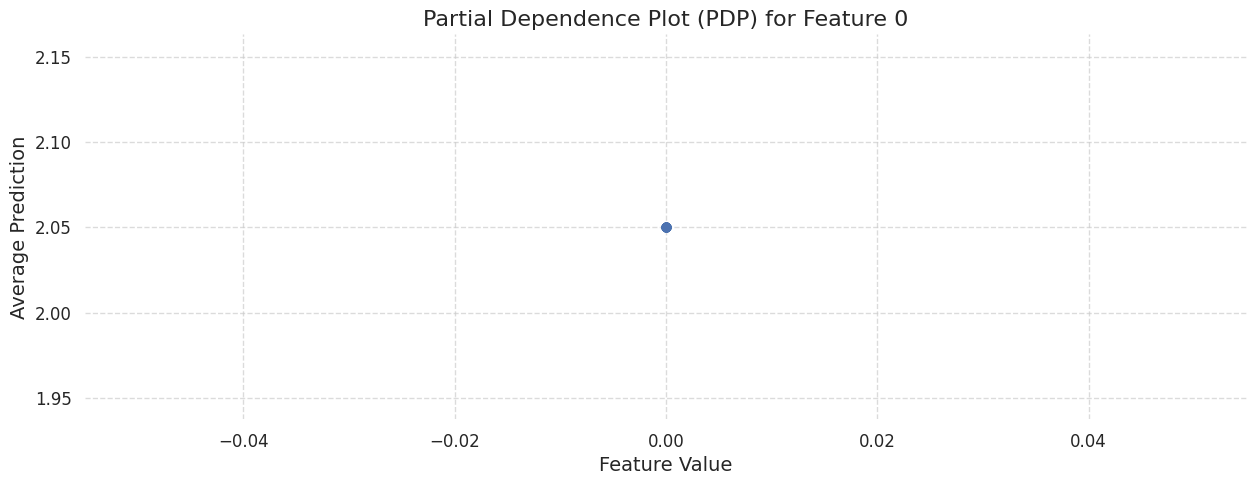

In [27]:
import seaborn as sns  # 定义部分依赖函数


def partial_dependence(feature_idx, feature_values, formula, dataset):
    predictions = []
    for value in feature_values:
        subs_dict = {
            'x_{}'.format(i + 1): value if i == feature_idx else dataset['test_input'][0, i]
            for i in range(dataset['test_input'].shape[1])
        }
        predict = float(formula.subs(subs_dict))
        predictions.append(predict)
    return np.array(predictions)


# dataset 是你的数据集，formula 是你的模型公式
# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp = 0  # 假设选择第一个特征进行 PDP
feature_values_pdp = np.linspace(min(dataset['test_input'][:, feature_index_pdp]), max(dataset['test_input'][:, feature_index_pdp]), num=50)
# 计算部分依赖
predictions_pdp = partial_dependence(feature_index_pdp, feature_values_pdp, formula, dataset)
# 绘制部分依赖图（PDP）# 设置Seaborn样式
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.plot(feature_values_pdp, predictions_pdp, marker='o', linestyle='-', color='b', linewidth=2, markersize=6)  # 添加标题和轴标签，并设置字体大小
plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.xlabel('Feature Value', fontsize=14)
plt.ylabel('Average Prediction', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# 添加背景和框架
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:



def ice(feature_idx, feature_values, formula, dataset):
    ice_predictions = []
    for i in range(dataset['test_input'].shape[0]):
        individual_predictions = []
        for value in feature_values:
            subs_dict = {
                'x_{}'.format(j + 1): value if j == feature_idx else dataset['test_input'][i, j]
                for j in range(dataset['test_input'].shape[1])
            }
            predict = float(formula.subs(subs_dict))
            individual_predictions.append(predict)
            ice_predictions.append(individual_predictions)
    return np.array(ice_predictions)


# 选择要绘制个体条件期望（ICE）的特征索引和范围
feature_index_ice = 0  # 假设选择第一个特征进行 ICE
feature_values_ice = np.linspace(min(dataset['test_input'][:, feature_index_ice]), max(dataset['test_input'][:, feature_index_ice]), num=10)

# 计算个体条件期望（ICE）
ice_predictions = ice(feature_index_ice, feature_values_ice, formula, dataset)
# 绘制个体条件期望（ICE）图
# 
plt.figure(figsize=(15, 5))
for i in range(len(ice_predictions)):
    plt.plot(feature_values_ice, ice_predictions[i], color='grey', alpha=0.2)
    plt.xlabel('Feature Value')
    plt.ylabel('Prediction')
    plt.title('Individual Conditional Expectation (ICE) Plot for Feature {}'.format(feature_index_ice))
    plt.grid(True)
    plt.show()
from mpl_toolkits.mplot3d import Axes3D  # 定义二维部分依赖函数




In [ ]:
def partial_dependence_2d(feature_idx1, feature_idx2, feature_values1, feature_values2, formula, dataset):
    predictions = np.zeros((len(feature_values1), len(feature_values2)))
    for i, value1 in enumerate(feature_values1):
        for j, value2 in enumerate(feature_values2):
            subs_dict = {
                'x_{}'.format(k + 1): value1 if k == feature_idx1 else value2 if k == feature_idx2 else dataset['test_input'][0, k]
                for k in range(dataset['test_input'].shape[1])
            }
            predict = float(formula.subs(subs_dict))
            predictions[i, j] = predict
    return predictions  # 选择要绘制二维部分依赖图的特征索引和范围




In [ ]:
feature_index1 = 0  # 第一个特征索引
feature_index2 = 1  # 第二个特征索引
feature_values1 = np.linspace(min(dataset['test_input'][:, feature_index1]), max(dataset['test_input'][:, feature_index1]), num=10)
feature_values2 = np.linspace(min(dataset['test_input'][:, feature_index2]), max(dataset['test_input'][:, feature_index2]), num=10)  # 计算二维部分依赖
predictions_2d_pdp = partial_dependence_2d(feature_index1, feature_index2, feature_values1, feature_values2, formula, dataset)  # 绘制二维部分依赖图（2D PDP）
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')  # 创建网格
X, Y = np.meshgrid(feature_values1, feature_values2)
surf = ax.plot_surface(X, Y, predictions_2d_pdp, cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.9)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
ax.set_xlabel('Feature {}'.format(feature_index1), fontsize=14, labelpad=10)
ax.set_ylabel('Feature {}'.format(feature_index2), fontsize=14, labelpad=10)
ax.set_zlabel('Average Prediction', fontsize=14, labelpad=10)
ax.set_title('2D Partial Dependence Plot (PDP) for Features {} and {}'.format(feature_index1, feature_index2), fontsize=16, pad=20)
ax.tick_params(axis='both', which='major', labelsize=12)  # 设置视角
ax.view_init(elev=60, azim=120)
plt.tight_layout()
plt.show()


l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


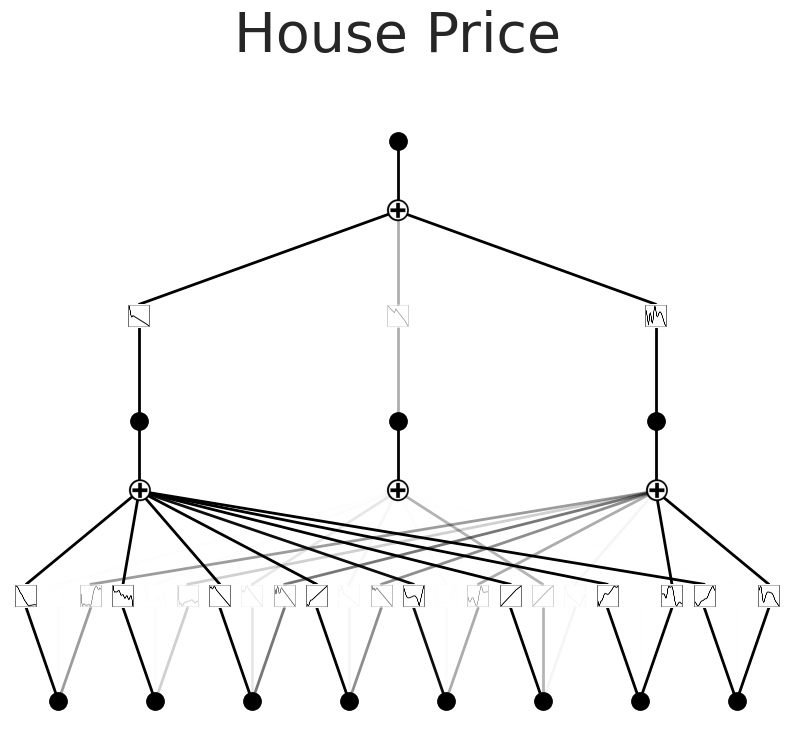

In [14]:
model.plot(beta=50, scale=1, out_vars=['House Price'])

In [15]:
import moviepy.video.io.ImageSequenceClip

video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4


Moviepy - Done !
Moviepy - video ready video.mp4


# Implementation of a Neural Network for comparison

## Misc Functions

In [16]:
class CalHousNet(nn.Module):
    def __init__(self):
        super(CalHousNet, self).__init__()
        self.fc1 = nn.Linear(8, 3)  # 8 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(3, 1)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, labels, reduction='sum')
            total_loss += loss.item()
            total_count += labels.size(0)

    # Calculate the average MSE over all batches
    average_mse = total_loss / total_count
    print(f'Mean Squared Error: {average_mse}')

In [17]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32).reshape(-1, 1)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=256, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_calhous_dataset()

In [18]:
dataiter = iter(train_loader)
data, labels = next(dataiter)
print("Train data shape: {}".format(data.shape))
print("Train target shape: {}".format(labels.shape))
dataiter = iter(test_loader)
data, labels = next(dataiter)
print("Test data shape: {}".format(data.shape))
print("Test target shape: {}".format(labels.shape))
print("====================================")

Train data shape: torch.Size([256, 8])
Train target shape: torch.Size([256, 1])
Test data shape: torch.Size([256, 8])
Test target shape: torch.Size([256, 1])


## Train and Evaluate the NN

In [19]:
model = CalHousNet().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 0.663138747215271
Epoch 2, Loss: 0.5634834170341492
Epoch 3, Loss: 0.48642945289611816
Epoch 4, Loss: 0.5768334865570068
Epoch 5, Loss: 0.46041715145111084
Epoch 6, Loss: 0.4934207797050476
Epoch 7, Loss: 0.49088963866233826
Epoch 8, Loss: 0.4052965044975281
Epoch 9, Loss: 0.3753213584423065
Epoch 10, Loss: 0.352811336517334
Epoch 11, Loss: 0.33598458766937256
Epoch 12, Loss: 0.49341753125190735
Epoch 13, Loss: 0.43929874897003174
Epoch 14, Loss: 0.2958683371543884
Epoch 15, Loss: 0.36147597432136536
Epoch 16, Loss: 0.3828045129776001
Epoch 17, Loss: 0.4127296805381775
Epoch 18, Loss: 0.37331241369247437
Epoch 19, Loss: 0.42638617753982544
Epoch 20, Loss: 0.32877928018569946
Epoch 21, Loss: 0.3330456018447876
Epoch 22, Loss: 0.33134469389915466
Epoch 23, Loss: 0.6187007427215576
Epoch 24, Loss: 0.3003910183906555
Epoch 25, Loss: 0.31181198358535767
Epoch 26, Loss: 0.4034554660320282
Epoch 27, Loss: 0.4532017111778259
Epoch 28, Loss: 0.33217868208885193
Epoch 29, Loss: 0.

In [ ]:
test_model(model, test_loader)